In [95]:
import numpy as np
import scipy as sp
import scipy.signal as signal
import sympy as sym

from scipy.io import wavfile

import matplotlib.pyplot as plt

from tqdm import tqdm

import utils

from ICA_functions import get_g_dg_d2g_over_dg, calc_h, calc_grad_W

from IPython.display import display, Math

# %matplotlib widget

In [96]:
np.random.seed(0) 
PLAY_AUDIO = False

In [97]:
fs1, x1 = wavfile.read('./experiment_2/first.wav')
fs2, x2 = wavfile.read('./experiment_2/second.wav')

Fs = fs1

x = np.stack((x2, x1), axis=0)

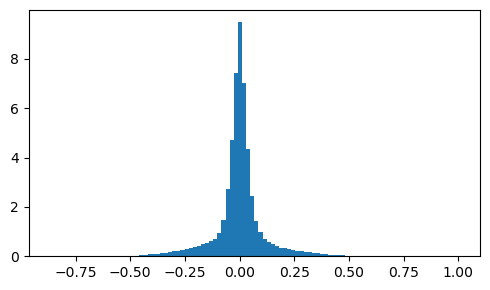

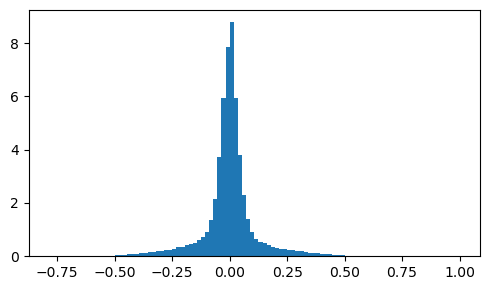

In [98]:
for i in range(x.shape[0]):
    plt.figure(figsize=(5, 3))
    plt.hist(x[i, :], bins=100, density=True)
    plt.tight_layout()
    plt.show()

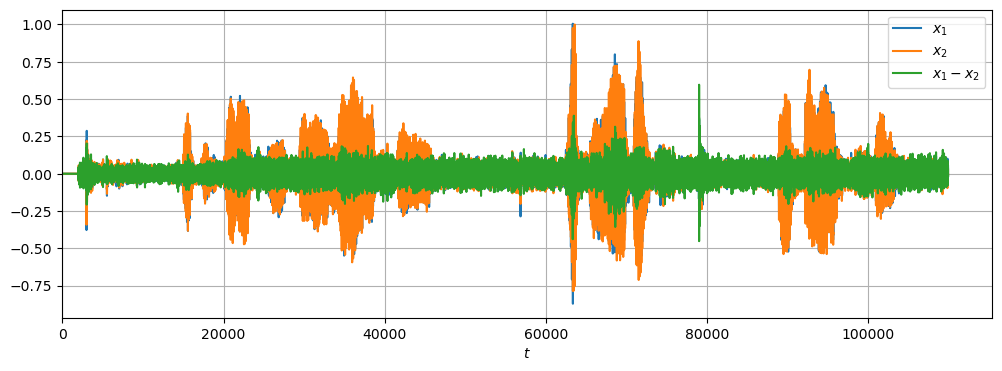

In [99]:
plt.figure(figsize=(12, 4))
plt.plot(x[0], label=r'$x_1$')
plt.plot(x[1], label=r'$x_2$')
plt.plot((x[0]-x[1]), label=r'$x_1 - x_2$')
plt.xlabel('$t$')
plt.legend()
plt.grid()
plt.xlim([0, None])
plt.show()

In [100]:
N = x.shape[0]  # number of source signals
M = N           # number of sensors (M=N)
T = x.shape[1]  # number of time samples (measurements)

W0 = np.eye(N, M, dtype=np.float64)  # unmixing initialization

maxiter = 1000

lr = 0.15 
lr_gamma = 0.995

In [101]:
# cdf options
cdf_opt_1 = lambda x: sym.integrate(sym.exp(-3.31*sym.Abs(x)) + 0.18*sym.exp(-0.91*sym.Abs(x)), (x)).simplify()  # mixture of laplacian ditributons
cdf_opt_2 = sym.tanh
cdf_opt_3 = lambda x: 0.5 * (1  + sym.erf(x/sym.sqrt(2)))  # normal distribution

cdf_opt_list = [cdf_opt_1, cdf_opt_2, cdf_opt_3]

In [102]:
sym_x = sym.Symbol('x', real=True)

for i, cdf_opt in enumerate(cdf_opt_list):
    display(Math(fr"$g_{{{i}}}(x)$"))
    display(cdf_opt(sym_x))
    display(Math(fr"$g'_{{{i}}}(x)$"))
    display(sym.diff(cdf_opt(sym_x)))
    display(Math(fr"$g''_{{{i}}}(x)$"))
    display(sym.diff(cdf_opt(sym_x), (sym_x, 2)))

<IPython.core.display.Math object>

Piecewise((0.197802197802198*exp(0.91*x) + 0.302114803625378*exp(3.31*x), x <= 0), (0.999834002855151 - 0.302114803625378*exp(-3.31*x) - 0.197802197802198*exp(-0.91*x), True))

<IPython.core.display.Math object>

Piecewise((0.18*exp(0.91*x) + 1.0*exp(3.31*x), x <= 0), (1.0*exp(-3.31*x) + 0.18*exp(-0.91*x), True))

<IPython.core.display.Math object>

Piecewise((0.1638*exp(0.91*x) + 3.31*exp(3.31*x), x <= 0), (-(3.31*exp(-3.31*x) + 0.1638*exp(-0.91*x)), True))

<IPython.core.display.Math object>

tanh(x)

<IPython.core.display.Math object>

1 - tanh(x)**2

<IPython.core.display.Math object>

2*(tanh(x)**2 - 1)*tanh(x)

<IPython.core.display.Math object>

0.5*erf(sqrt(2)*x/2) + 0.5

<IPython.core.display.Math object>

0.5*sqrt(2)*exp(-x**2/2)/sqrt(pi)

<IPython.core.display.Math object>

-0.5*sqrt(2)*x*exp(-x**2/2)/sqrt(pi)

In [103]:
# automatic symbolic g', g''/g' calculation with conversion to numpy
# different CDFs for two signals

g_1, dg_1, d2g_over_dg_1 = get_g_dg_d2g_over_dg(lambda x: cdf_opt_3(x))
g_2, dg_2, d2g_over_dg_2 = get_g_dg_d2g_over_dg(lambda x: cdf_opt_1(x)) 

g = lambda x: np.stack((g_1(x[0, :]), g_2(x[1, :])))
dg = lambda x: np.stack((dg_1(x[0, :]), dg_2(x[1, :])))
d2g_over_dg = lambda x: np.stack((d2g_over_dg_1(x[0, :]), d2g_over_dg_2(x[1, :]))) 

x = np.einsum('cn,c->cn', x, 1/np.sqrt(np.mean(x**2, axis=-1)))  

In [104]:
scaling_coef = 1 
x *= scaling_coef
lr /= scaling_coef

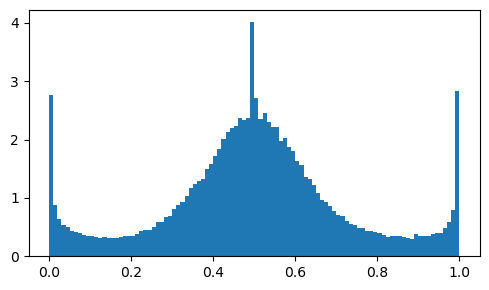

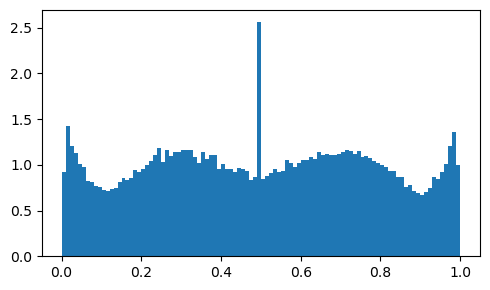

In [105]:
for i in range(x.shape[0]):
    plt.figure(figsize=(5, 3))
    plt.hist(g(x)[i], bins=100, density=True)
    plt.tight_layout()
    plt.show()

In [106]:
W = W0.copy()
y = W @ x

In [107]:
# x = np.einsum('cn,c->cn', x, 1/np.mean(x**2, axis=-1))

In [108]:
np.mean(x**2), np.mean(y**2)

(1.0, 1.0)

In [109]:
if PLAY_AUDIO:
    utils.play_audios(x, Fs, norm_coef=0.1)

In [110]:
h_log = np.zeros(maxiter)
grad_norm_log = np.zeros(maxiter)

In [111]:
pbar = tqdm(range(maxiter))
for it in pbar:
    y = W @ x
    
    h = calc_h(T, dg(y), W)
    
    grad_W = calc_grad_W(T, x, d2g_over_dg(y), W)
    
    W += lr * grad_W
    lr *= (lr_gamma)
    
    h_log[it] = h
    grad_norm_log[it] = np.linalg.norm(grad_W, ord=2)
    
    if it%20 == 0:
        pbar.set_postfix({'grad_norm' : f"{grad_norm_log[it]:.3g}",
                        'h' : f"{h_log[it]:.3g}"})

100%|██████████| 1000/1000 [00:12<00:00, 79.23it/s, grad_norm=0.00723, h=-1.48]


In [112]:
y = W @ x

Rescale signals

In [113]:
y = np.einsum('cn,c->cn', y, 1/np.sqrt(np.mean(y**2, axis=-1)))

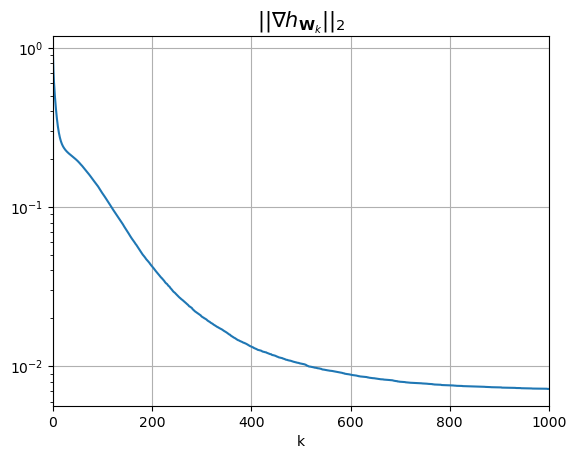

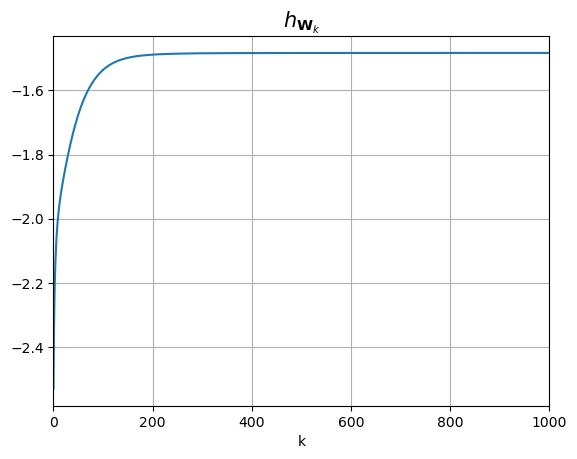

In [114]:
plt.figure()
plt.title(r'$ ||\nabla h_{\mathbf{W}_k}||_{2} $', fontsize=15)
plt.semilogy(grad_norm_log)
plt.xlim([0, maxiter])
plt.grid()
plt.xlabel('k')
plt.show()

plt.figure()
plt.title(r'$h_{\mathbf{W}_k}$', fontsize=15)
plt.plot(h_log)
plt.xlim([0, maxiter])
plt.grid()
plt.xlabel('k')
plt.show()

Mean value and difference --- obvious, but best result one could achieve with this elementary model. 

Still, it's an interesting interpretable result.

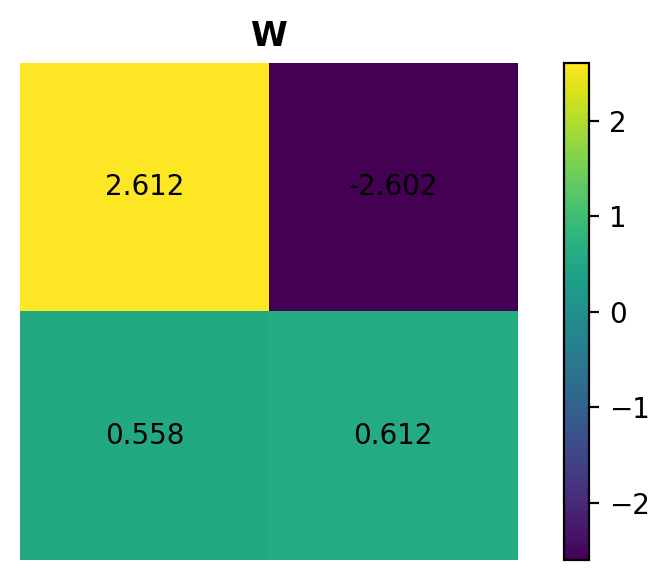

In [115]:
utils.plot_matrix(W, f'$\mathbf{{W}}$')

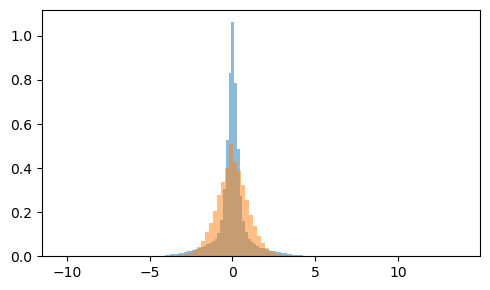

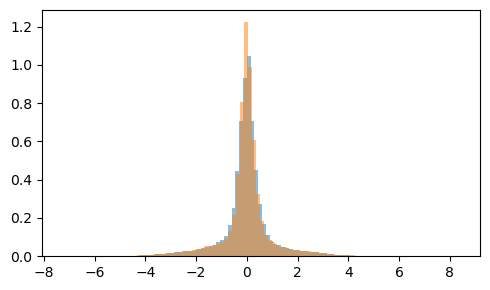

In [116]:
for i in range(x.shape[0]):
    plt.figure(figsize=(5, 3))
    plt.hist((x[i, :]), bins=100, density=True, alpha=0.5)
    plt.hist((y[i, :]), bins=100, density=True, alpha=0.5)
    plt.tight_layout()
    plt.show()

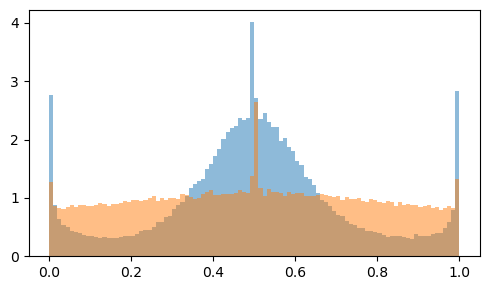

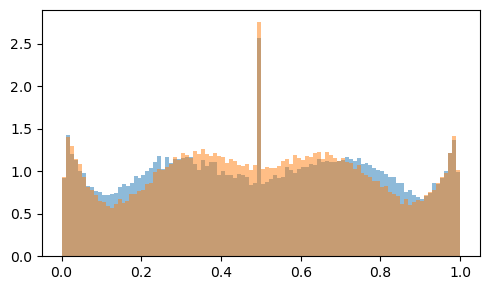

In [117]:
for i in range(x.shape[0]):
    plt.figure(figsize=(5, 3))
    plt.hist(g(x)[i], bins=100, density=True, alpha=0.5)
    plt.hist(g(y)[i], bins=100, density=True, alpha=0.5)
    plt.tight_layout()
    plt.show()

In [118]:
if PLAY_AUDIO:
    utils.play_audios(x[0:1, :], Fs, norm_coef=0.1)
    utils.play_audios(y[0:1, :], Fs, norm_coef=0.1)

    utils.play_audios(x[1:2, :], Fs, norm_coef=0.1)
    utils.play_audios(y[1:2, :], Fs, norm_coef=0.1)

In [119]:
np.mean(y**2), np.mean(x**2)

(1.0000000000000002, 1.0)